# Advances in Computing with Uncertainties: Lecture 7

* Instructor: Laura Lyman
* Date: 12 October 2021
* Fall Quarter, Stanford University

## Objectives and Summary

1. Experiment with the limits of Gaussian Quadrature (GQ) (very wiggly functions need more quadrature points) 
2. Review the purpose of the function $\hat{f}$
   + Emphasize that $\hat{f}$, while matching $f$ at the quadrature nodes, is not a great estimator of $f$ itself, but it *is* a solid estimator of the *integral* of $f$. 
   + When $f$ is a function of a random variable, this is why GQ for UQ doesn't give us all the information about the distribution of our output; it only approximates the *expectation* of our output well.
3. Compare Monte Carlo (MC) and Gaussian Quadrature (GQ) by using both to solve an integration problem
4. Verify empirically that most GQ nodes cannot be reused as we increase the number of quadrature points.
    +  For an $(n+1)$ point quadrature rule, there is at least one node between consecutive nodes of the $n$-point quadrature rule. 
    + This means at *most* 2 quadrature nodes can be reused between an $n$ and $n+1$ rule for any $n$. (See the lecture notes for this argument.) In fact, that 2 is an upper bound; often we can't reuse any nodes.
    + To have reusable (or *nested*) nodes (and thus reusable function evaluations $f(\lambda_k))$, people  consider other quadrature methods
5. Survey Clenshaw-Curtis (CC) Quadrature
   + Nested nodes
   + Degree of exactness is $n + 1$ (as opposed to $2 n - 1$ for GQ)
6. Introduce `quadpy`, one of many quadrature software resources for other quadrature methods

In [2]:
import numpy as np
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
# Improve the quality of figures
mpl.rcParams['figure.dpi'] = 300

## The purpose of $\hat{f}$

Recall that $\hat{f}(x) = \sum_{k=1}^n f(\lambda_k) \ell_k(x)$, for Lagrange interpolating polynomial $\ell_k$. Let's look at the function $f(x) = (\cos(50 x) \sin(20 x))^2$ from Lecture 4. We wish to estimate/compute $\int_{-1}^1 f(x) dx = \int_{-1}^1 (\cos(50 x) \sin(20 x))^2 dx$ by instead computing $\int_{-1}^1 \hat{f}(x) dx.$ 

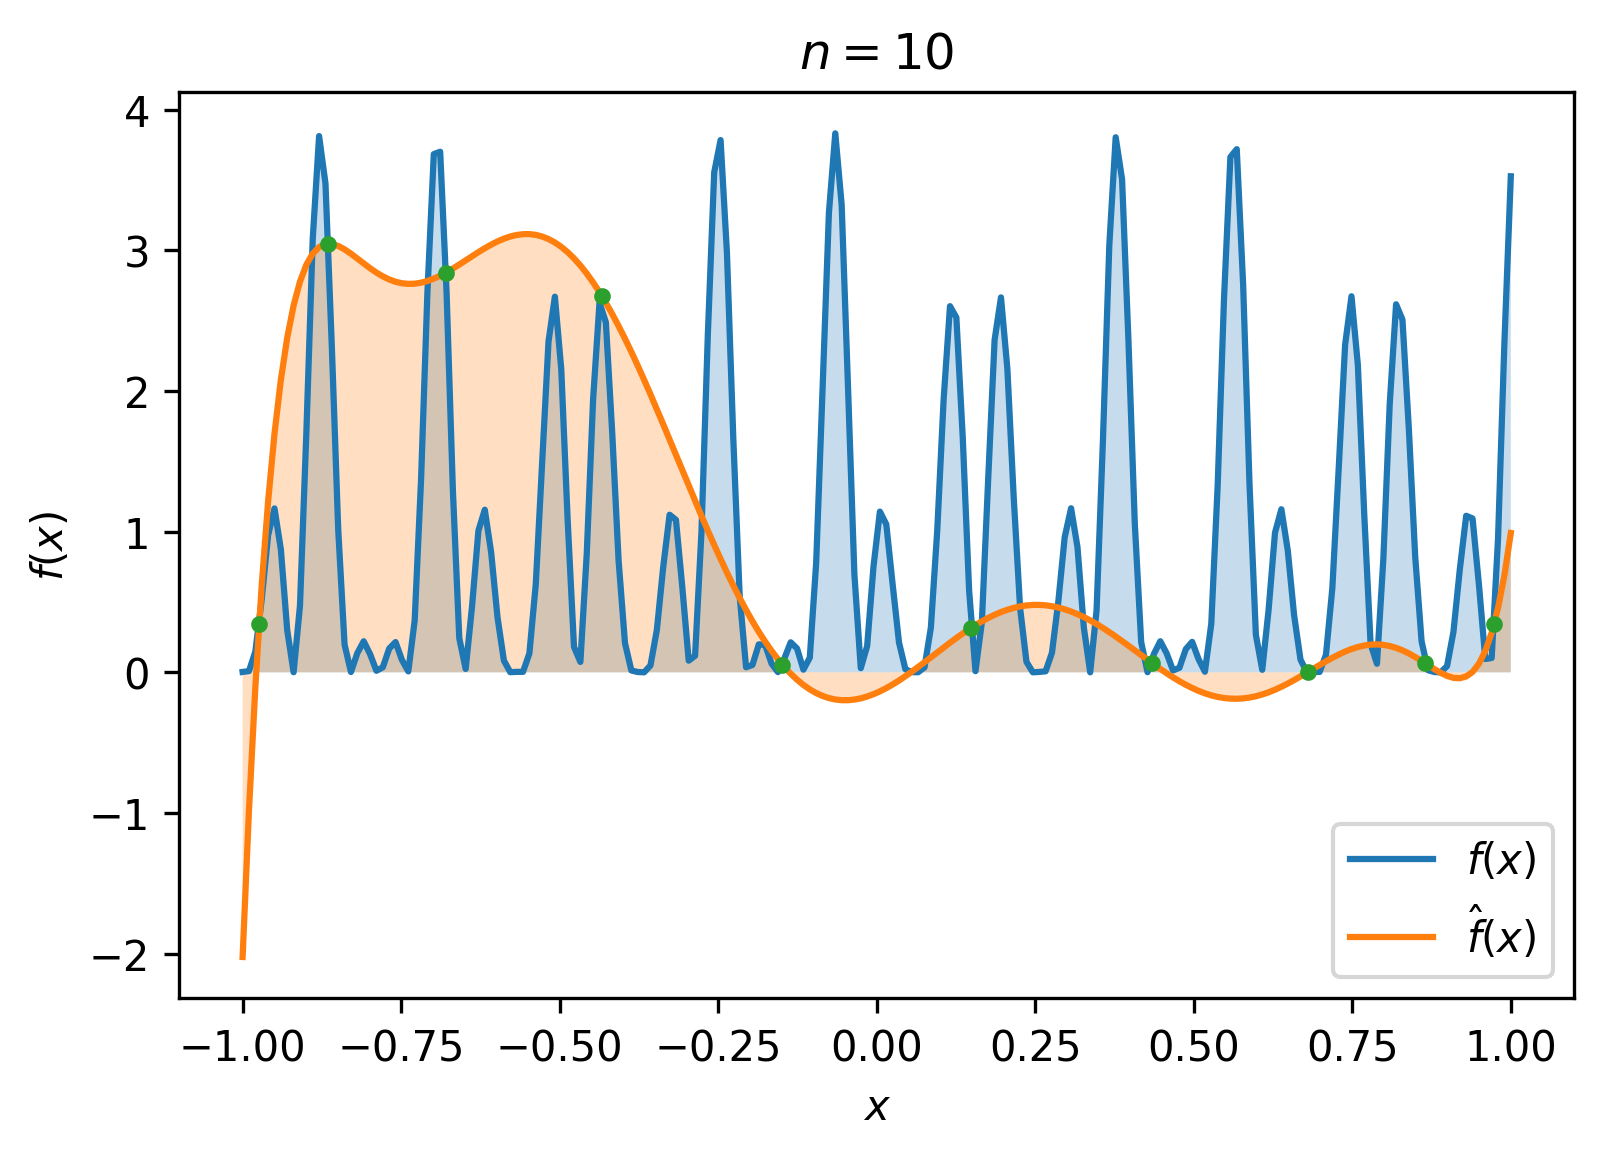

In [3]:
# f = lambda x: np.sin(x)*np.cos(x * 3)+ x**2
# The function we will integrate, which was used in the notebook of Lecture 4
f_wild = lambda x: (np.cos(50 * x) + np.sin(20 * x)) ** 2
f = f_wild
n = 10
# Get the roots of the n - 1 degree polynomial with w[x] = 1 in [-1, 1] (Legendre, NOT Lagrange)
# Technically, we need the Legendre polynomials with w[x] = 1/2 (these integrate to 1 on [-1,1]) to insure that
# the polynomials are orthonormal and not just orthogonal. However, the roots of the non-normalized Legendre
# polys will be the same as the roots of the normalized ones, so we're okay here

# Get the roots of the n degree polynomial
X, w = scipy.special.roots_legendre(n)

# Get the Lagrange interpolating polynomial
f_hat = scipy.interpolate.lagrange(X, f(X))

# Visualize the actual function and the Legendre interpolating polynomial
fig, ax = plt.subplots()
x = np.linspace(-1, 1, 200)

ax.plot(x, f(x))

ax.fill_between(x, np.zeros(x.shape), f(x), alpha=0.25)
ax.plot(x, f_hat(x))
ax.fill_between(x, np.zeros(x.shape), f_hat(x), alpha=0.25)
ax.plot(X, f(X), '.')
ax.set_xlabel('$x$')
ax.set_title('$n=%d$' % n)
ax.set_ylabel('$f(x)$')
plt.legend(['$f(x)$', '$\hat{f}(x)$'], loc='best');

We can see that $\hat{f}$, while matching $f$ at the quadrature nodes, is not a great estimator of $f$ itself -- and that's okay. The point of $\hat{f}$ is to be a solid estimator of the *integral* of $f$. 

In [4]:
[lambdas,weights] = np.polynomial.legendre.leggauss(n)
int_est = 0
for i in range(n):
    int_est += f(lambdas[i])*weights[i]
print("GQ integral estimate: %s" % str(int_est))
# "True" answer (via SciPy) as a sanity check
true_ans = scipy.integrate.quad(f,-1,1)[0]
print("Answer from SciPy: %s " % str(true_ans))

GQ integral estimate: 1.9822022671094355
Answer from SciPy: 1.9763085145769181 


When $f$ is a function of a random variable, this is why GQ for UQ doesn't give us all the information about the distribution of our output; it only approximates the *expectation* of our output well.

 + Try lowering the number of quadrature points. How does GQ do with estimating the integral?
 + Try commenting out `f_wild` and uncommenting the original `f = np.sin(x)*np.cos(x * 3)+ x^2`. How does GQ do with this less-wiggly entity?

## Compare GQ to MC Integration (Solve the Same Problem)

Let's reuse some of our code.

In [5]:
def get_mc_estimate(max_n = 1000, func = f, sampler = np.random.rand):
    """
    Return the the MC estimate of the 1D integral of a user-defined f function.
    
    :param max_n:   Maximum number of sample
    :param func:    The function to integrate
    :param sampler: A function that samples the X_i;
                    the default is np.random.rand, which is the uniform distribution on [0,1)
    """
    S_n = np.ndarray((max_n,))  # Sample mean; an array with the running estimates of the expecation
    s = 0.                      # Variable to keep track of the sum
    for i in range(max_n):
        # Sample X_i
        X_i = sampler(-1,1)
        # Update the sum
        s += f(X_i)
        # The current approximation of the integral is
        S_n[i] = s / (i + 1)
    return(S_n)

1.978993186028397


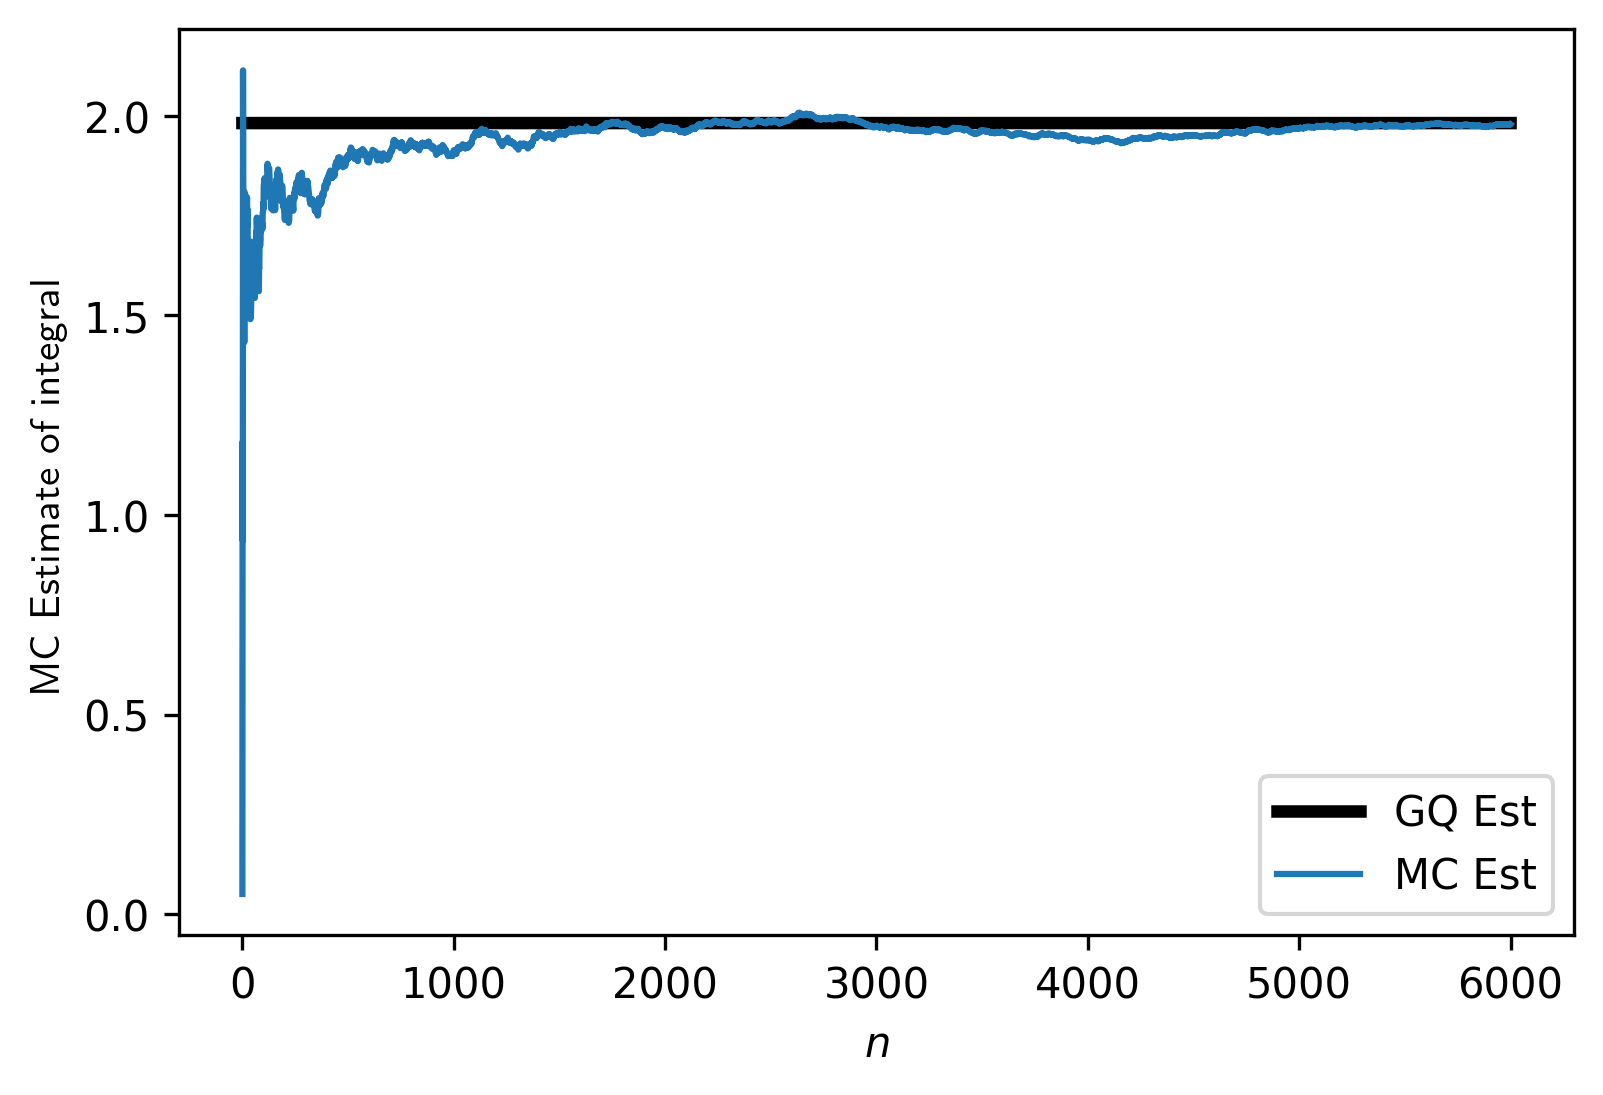

In [6]:
# Number of independent MC runs
num_mc = 1
# Maximum number of samples to take per MC run
max_n  = 6000
fig, ax = plt.subplots()
# Plot the expected value for reference from GQ
ax.plot(np.arange(1, max_n+1), int_est*np.ones(max_n), color='black', linewidth=3.0, label = "GQ Est")

for _ in range(num_mc):
    # Now use a uniform distribution
    S_n_vals = get_mc_estimate(max_n = max_n, func = f, sampler = np.random.uniform)
    # True integral value is 2 times the MC integral
    ax.plot(np.arange(1, max_n+1), 2*S_n_vals, label = "MC Est")

ax.set_xlabel('$n$')
ax.set_ylabel('MC Estimate of integral', usetex = True);
ax.legend()
print(2*S_n_vals[-1])

## Reusing quadrature nodes?

Notice that the Gaussian quadrature nodes are **not** nested. Every time you increase the number of quadrature points, you get completely different nodes. In lecture, we proved the following.

**Theorem.** Let $\{\pi_k\}_{k=0}^\infty$ be a sequence of orthogonal polynomials on $\mathcal{D} \subseteq \mathbb{R}$ with respect to our positive weight function $w$ (which has our usual assumptions on it); further, we assume $\deg(\pi_k) = k$ for all $k$. Let $\lambda_1^{(n)}, \ldots, \lambda_{n}^{(n)}$ denote the roots of $\pi_n$, labeled such that $\lambda_1^{(1)} < \cdots < \lambda_{n}^{(n)}.$  Then between every pair of consequtive roots $\lambda_k^{(n)}$ and $\lambda_{k+1}^{(n)},$ there is at least one root of $\pi_m$ for any $m > n.$ 


This means that you cannot reuse the function evaluations you have seen so far, which is bad if evaluating $f$ at a given $\lambda_k$ is expensive. In fact, in lecture we argued that at *most* 2 quadrature nodes can be reused between an $n$ and $n+1$ rule for any $n$. In fact, that 2 is an upper bound; sometimes we can't reuse any nodes. Let's see this idea in action.

Below, we plot the roots of the *Legendre polynomials*. The only repeated root occurs at $x = 0$. (The dashed yellow line at $x = 0$ actually has magenta and orange lines behind it for $\pi_3$ and $\pi_1$, respectively.) 

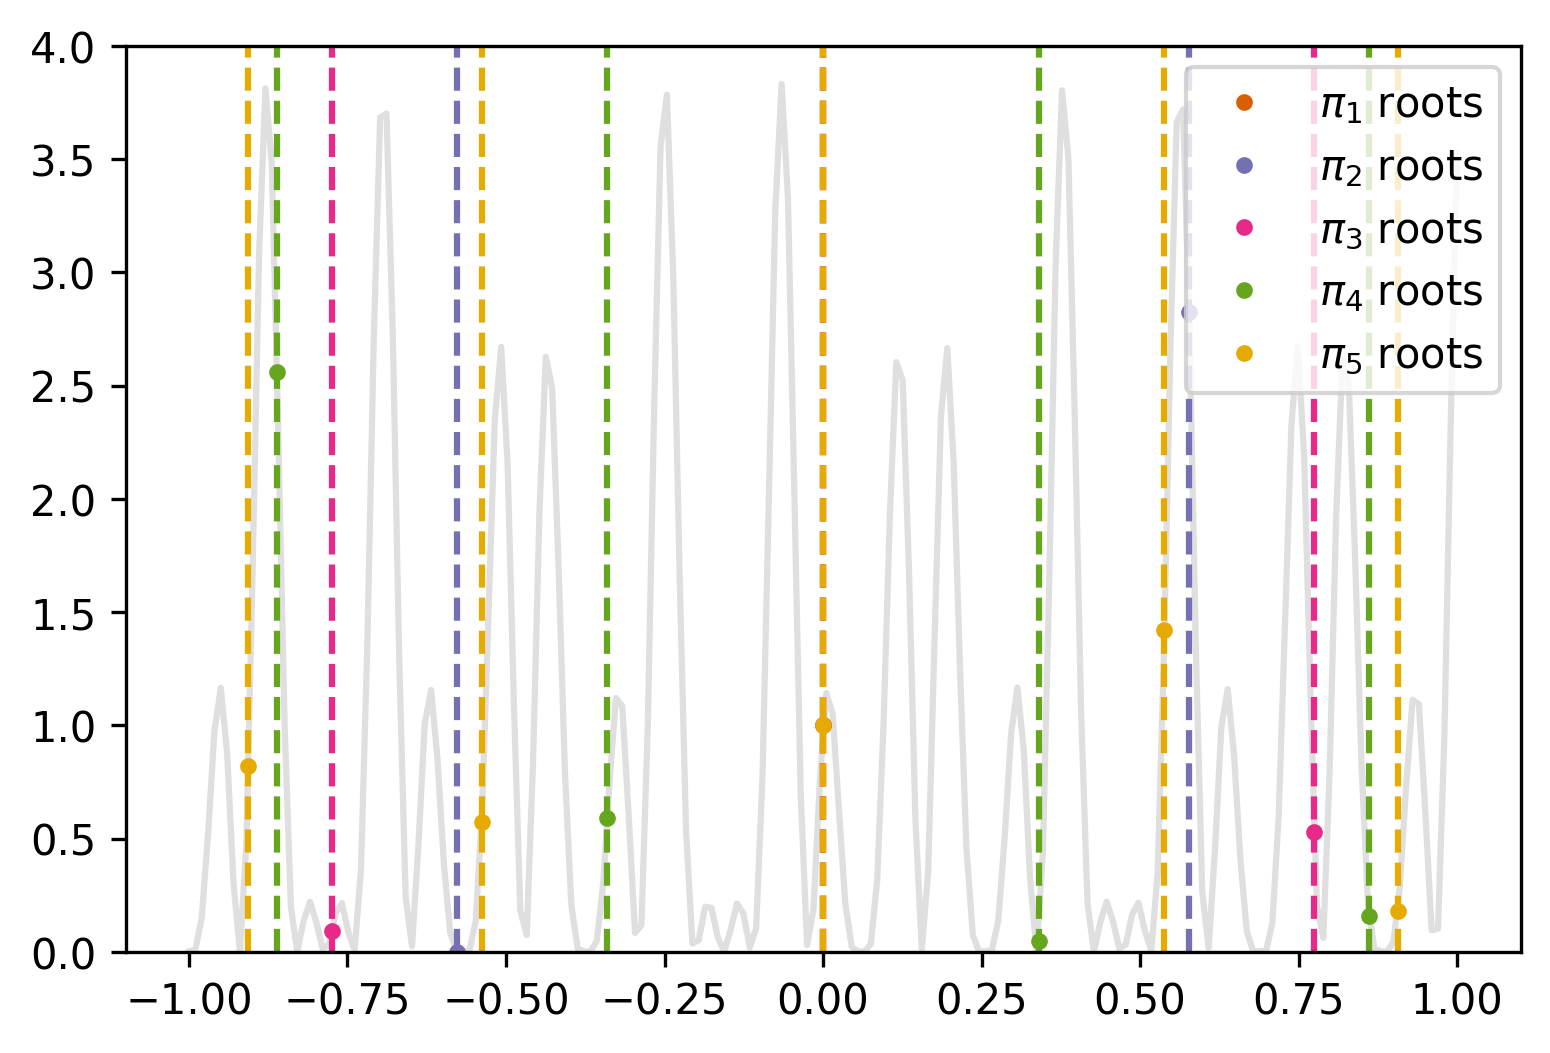

In [7]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('Dark2')
max_deg = 5
x = np.linspace(-1, 1, 200)
ax.plot(x, f(x), color = 'gray', alpha = 0.25)
ax.set_ylim([0,4])
for k in range(1, max_deg + 1):
    # Get the roots of the degree k Legendre polynomial
    X, w = scipy.special.roots_legendre(k)
    label = "$\pi_%d$ roots" % k
    ax.plot(X, f(X), '.', label = label, color = cmap.colors[k])
    for i in range(k): plt.axvline(x = X[i],color = cmap.colors[k], linestyle='dashed')
plt.legend(loc='best')
plt.show()

Let the superscript $n$ in $\hat{f}^{(n)} := \sum_{k=1}^n \nu_k f(\lambda_k^{(n)})$ denote an $n$-point quadrature rule. We can see the $\hat{f}^{(n)}$ pass through their corresponding quadrature nodes, along with the integrals of each $\hat{f}^{(n)}$.

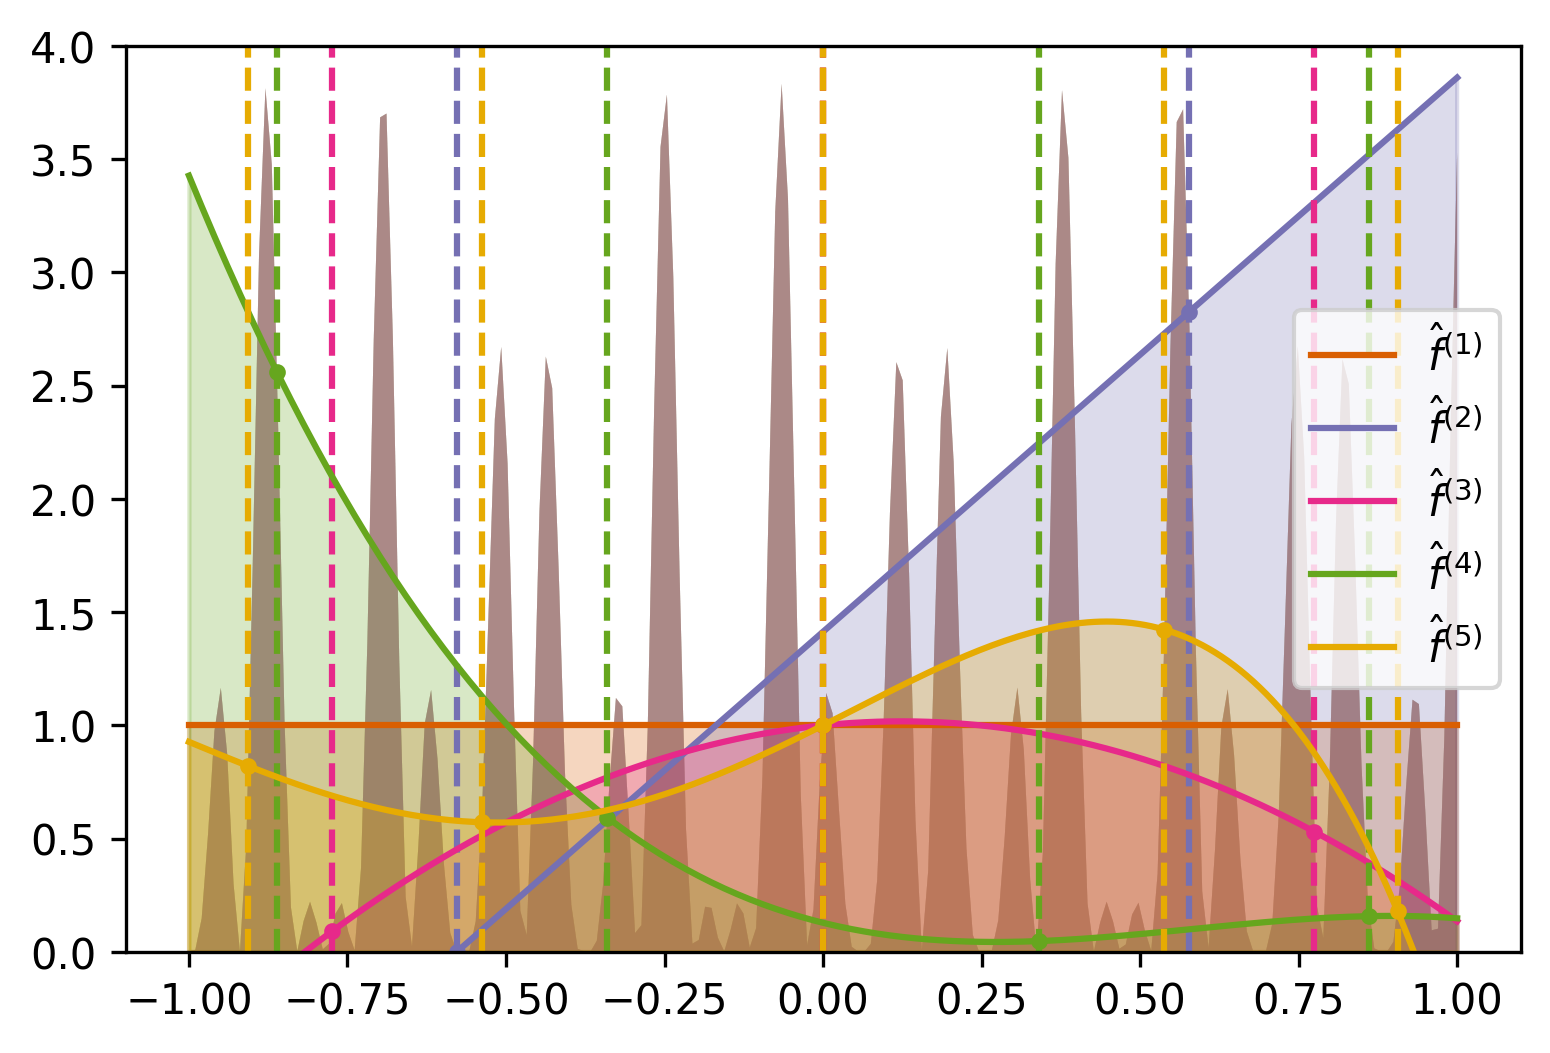

In [8]:
# Get the roots of the n degree polynomial
X, w = scipy.special.roots_legendre(n)
fig, ax = plt.subplots()
cmap = plt.get_cmap('Dark2')
max_deg = 5
x = np.linspace(-1, 1, 200)
# ax.plot(x, f(x), color = 'gray')
ax.set_ylim([0,4])
for k in range(1, max_deg + 1):
    # Get the roots of the degree k Legendre polynomial
    X, w = scipy.special.roots_legendre(k)
    # Get the Lagrange interpolating polynomial
    f_hat = scipy.interpolate.lagrange(X, f(X))
    label_fhat = "$\hat{f}^{(%d)}$" % k
    ax.fill_between(x, np.zeros(x.shape), f(x), alpha=0.25)
    ax.plot(x, f_hat(x),color = cmap.colors[k], label = label_fhat)
    ax.fill_between(x, np.zeros(x.shape), f_hat(x), alpha=0.25, color = cmap.colors[k])
    ax.plot(X, f(X), '.', color = cmap.colors[k])
    for i in range(k): plt.axvline(x = X[i],color = cmap.colors[k], linestyle='dashed')
plt.legend(loc='best')
plt.show()

## Clenshaw-Curtis Quadrature

We are looking for a quadrature rule with nested nodes. As we increase the number of points, we would like to be able to reuse the function evaluations.

The derivation is quite involved, but it goes like this.
Let us look at the case $a=-1, b=1$.
First, we transform the integral by setting $x = \cos\theta$:
$$
\int_{-1}^1 f(x)dx = \int_0^\pi f(\cos\theta)\sin(\theta)d\theta.
$$
Then, expand the $f(\cos\theta)$ in cosine series:
$$
f(\cos\theta) = \frac{a_0}{2} + \sum_{k=1}^\infty a_k \cos(k\theta),
$$
where
$$
a_k = \frac{2}{\pi}\int_0^\pi f(\cos\theta)\cos(k\theta)d\theta.
$$
From this, we get:
$$
\int_0^\pi f(\cos\theta)\sin\theta d\theta = a_0 + \sum_{k=1}^\infty\frac{2a_k}{1 - (2k)^2}.
$$
Now, using the [Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist–Shannon_sampling_theorem) from signal processing, we see that we can evaluate the coefficients $a_k$ for $k\le n$ **exactly** if we evaluate $f(\cos\theta)$ at $n+1$ equidistant nodes $\theta_j = \frac{j\pi}{n}, j=0,\dots,n$. It is:
$$
a_k = \frac{2}{n}\left((-1)^k\frac{f(-1)}{2} + \frac{f(1)}{2} + \sum_{j=1}^{n-1}f\left(\cos\frac{j\pi}{n}\right)\cos\frac{kj\pi}{n}\right).
$$
So, we see that the nodes are
$$
\lambda_j = \cos\frac{j\pi}{n},
$$
for $j=0,1,\dots,n$ and that they are indeed nested (double $n$).
To get the weights, you re-arrange/group terms in the summation and you try to identify the $\nu_j$ coefficients.

**Note.** Clenshaw-Curtis quadrature for $n$ points only integrates exactly polynomials up to degree $n+1$. But it can be much faster.

**Note.** I won't go into any more derivations around this. If you are looking for an idea for a final project, you can investigate CC quadrature in more detail. 

For CC-quadrature and the like, I recommend simply using existing software, as implementing it yourself can become involved. 

# Software tool spotlight

<p align="center">
  <a href="https://github.com/nschloe/quadpy"><img alt="quadpy" src="https://nschloe.github.io/quadpy/logo-with-text.svg" width="60%"></a>
</p>

+ **Github**: https://github.com/nschloe/quadpy
+ **Author**: Nico Schlömer

You can install
`quadpy` [from the Python Package Index](https://pypi.org/project/quadpy/) with `pip install quadpy` (or `pip3 install quadpy`). Be sure to import it after `numpy`.

In [10]:
import quadpy

This tool provides a variety of integration schemes. 

### Line segment (_C<sub>1</sub>_)

<img src="https://nschloe.github.io/quadpy/line-segment-gauss-legendre-20.svg" width="50%">

- [Chebyshev-Gauss](src/quadpy/c1/_chebyshev_gauss.py) (type 1 and 2, arbitrary degree)
- [Clenshaw-Curtis](src/quadpy/c1/_clenshaw_curtis.py) (arbitrary degree)
- [Fejér](src/quadpy/c1/_fejer.py) (type 1 and 2, arbitrary degree)
- [Gauss-Jacobi](src/quadpy/c1/_gauss_jacobi.py) (arbitrary degree)
- [Gauss-Legendre](src/quadpy/c1/_gauss_legendre.py) (arbitrary degree)
- [Gauss-Lobatto](src/quadpy/c1/_gauss_lobatto.py) (arbitrary degree)
- [Gauss-Kronrod](src/quadpy/c1/_gauss_kronrod.py) (arbitrary degree)
- [Gauss-Patterson](src/quadpy/c1/_gauss_patterson.py) (9 nested schemes up to degree 767)
- [Gauss-Radau](src/quadpy/c1/_gauss_radau.py) (arbitrary degree)
- [Newton-Cotes](src/quadpy/c1/_newton_cotes.py) (open and closed, arbitrary degree)

[See
here](https://github.com/nschloe/quadpy/wiki/Creating-your-own-Gauss-quadrature-in-two-simple-steps)
for how to generate Gauss formulas for your own weight functions.

For instance, `Chebyshev-Gauss`, `Gauss-Jacobi`, `Gauss-Legendre`, etc. are all Gaussian Quadrature with Chebyshev, Jacobi, or Legendre polynomials (respectively) chosen as the orthogonal polynomial family. 

<quadrature scheme for C1>
  name:                 Clenshaw-Curtis
  source:               Fast Construction of the Fejér and Clenshaw–Curtis Quadrature Rules
                        J. Waldvogel
                        BIT Numerical Mathematics, vol. 46, no. 1, pp. 195–202, 2006
                        https://doi.org/10.1007/s10543-006-0045-4
  degree:               5
  num points/weights:   5
  max/min weight ratio: 1.200e+01
  test tolerance:       1e-14
  all weights positive: True


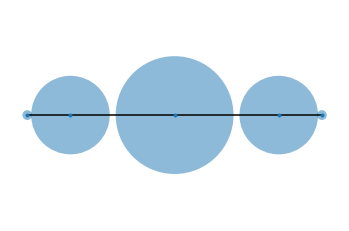

In [11]:
%matplotlib inline
num_quad_pts = 5
scheme = quadpy.c1.clenshaw_curtis(num_quad_pts)
print(scheme)
scheme.show()

CC quadrature integrates on $[-1,1]$. In the diagram, the dots represent the quadrature nodes, 

In [12]:
scheme.points

array([-1.00000000e+00, -7.07106781e-01, -6.12323400e-17,  7.07106781e-01,
        1.00000000e+00])

which are located at $\{ -1, -\frac{1}{\sqrt{2}}, 0, \frac{1}{\sqrt{2}}, 1.\}$ The blue circles represent the weights $\nu_k$ given at each point, i.e.

In [13]:
print(scheme.weights)

[0.06666667 0.53333333 0.8        0.53333333 0.06666667]


So the largest weight is given to the quadrature node at the origin, with the smallest weights given to those at the end points. 

This also means that if CC quadrature were being used to estimate the length of the line segment $[-1,1]$, i.e. $\int_{-1}^1 f(s) ds$ with $f(s) = 1$, the circle portions intersecting with the line $[-1,1]$ represent the length portions covered by each quadrature node $\nu_k.$ Don't be confused by the gaps between the cirlces; those parts of the line are still "covered"! They are accounted for by the intersection of small circles at the endpoints with their neighboring circles. (Even if the blue portions overlap, their areas are counted individually.) Indeed, we can verify that if we add the weights up, we get the desired length of 2

In [14]:
np.sum(scheme.weights)

2.0000000000000004

Of course that is silly for a line segment. But this gets more interesting when we consider other domains.

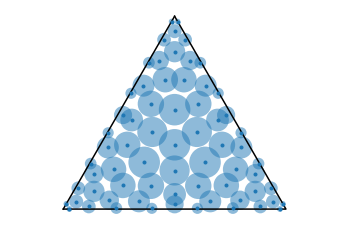

<quadrature scheme for T2>
  name:                 Witherden-Vincent 18
  source:               On the identification of symmetric quadrature rules for finite element methods
                        F.D. Witherden, P.E. Vincent
                        Computers & Mathematics with Applications, vol. 69, no. 10, pp. 1232–1241, 2015
                        https://doi.org/10.1016/j.camwa.2015.03.017
  degree:               18
  num points/weights:   67
  max/min weight ratio: 2.983e+01
  test tolerance:       8.864e-16
  point position:       strictly inside
  all weights positive: True


In [15]:
degree = 18
scheme = quadpy.t2.get_good_scheme(degree)
scheme.show()
print(scheme)

Here, `get_good_scheme` is simply a dictionary with various quadrature methods that selects a method based on the degree of exactness you want. That degree is a function of the number of quadrature points and vice versa. For degree 18, it happens to use a Witherden-Vincent scheme (2015, 19 schemes total that are exact for multi-dimensional polynomials up to degree 20). 

Of course, we don't need to ensure accuracy for polynomials up to degree 20 if we only care about triangle area. The triangle displayed is normalized to have area 1. We can see that with just 1 quadrature point is sufficient, since the function we are integrating (f(x) = 1) is a polynomial of degree at most 1 (in fact, it has degree 0). 

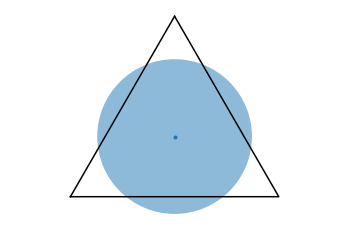

1.0
<quadrature scheme for T2>
  name:                 Centroid rule
  degree:               1
  num points/weights:   1
  max/min weight ratio: 1.000e+00
  test tolerance:       7.85e-17
  point position:       strictly inside
  all weights positive: True


In [16]:
num_quad_pts = 1
scheme = quadpy.t2.get_good_scheme(num_quad_pts)
scheme.show()
print(np.sum(scheme.weights))
print(scheme)

We can define our own triangles and integrate an arbitrary $f$ on them, say $f(x,y) = \sin(x) \sin(y).$ 

In [17]:
def f(x): return np.sin(x[0]) * np.sin(x[1])

# Coordinates of an equilateral triangle of side length 1 
triangle = np.array([[0.0, 0.0], [1.0, 0.0], [0.5, np.sqrt(3)/2]])

# Get a "good" scheme of degree 10
scheme = quadpy.t2.get_good_scheme(10)
scheme.integrate(f, triangle)

0.056989133906303696

Of course, we can sanity check this. Letting $T$ be the triangle,
\begin{alignat*}{2}
\int_T f(x,y) dx dy &= \int_{x = 0}^{1/2} \int_{y = 0}^{\sqrt{3} x} f(x,y) dx dy \quad &&\text{[left half of triangle]} \\
&+ \int_{x = 1/2}^1 \int_{y = 0}^{-\sqrt{3}(x-1)} f(x,y) dx dy \quad &&\text{[right half of triangle]},
\end{alignat*}

The first integral by [Wolfram Alpha](https://www.wolframalpha.com/input/?i=integral+of+sin%28x%29sin%28y%29+from+x+%3D+0+to+1%2F2+and+y+%3D+0+to+sqrt%283%29+x) is $\approx 0.0218637...$ and the [second one](https://www.wolframalpha.com/input/?i=integral+of+sin%28x%29sin%28y%29+from+x+%3D+1%2F2+to+1+and+y+%3D+0+to+-sqrt%283%29+%28x+-+1%29) is $\approx 0.0351254...$, which sums to our answer ($\approx 0.0569891...$). Cool! 

We can use this package for **CC quadrature** very easily. 

In [18]:
alpha = 3
f = lambda x: np.cos(alpha*x)
# Cosine is 'like' a polynomial of degree 2*alpha on [-1,1], because the coefficients of x^k terms for
# k > 2 alpha are all less than 1, and those for k <= 2 alpha are at least 1.
# E.g. the Taylor expansion of cos(3x) around x = 0 is
# 1 - (9 x^2)/2 + (27 x^4)/8 - (81 x^6)/80 + O(x^7), where the O(x^7) terms all have 
# coefficients less than 1
# So picking 2 * alpha = 6 quadrature points seems good
num_quad_pts = 6
scheme = quadpy.c1.clenshaw_curtis(num_quad_pts)
print(scheme)
scheme.integrate(f, [-1,1])

<quadrature scheme for C1>
  name:                 Clenshaw-Curtis
  source:               Fast Construction of the Fejér and Clenshaw–Curtis Quadrature Rules
                        J. Waldvogel
                        BIT Numerical Mathematics, vol. 46, no. 1, pp. 195–202, 2006
                        https://doi.org/10.1007/s10543-006-0045-4
  degree:               6
  num points/weights:   6
  max/min weight ratio: 1.498e+01
  test tolerance:       1e-14
  all weights positive: True


0.09513709877541685

Of course, if you want to use CC quadrature for an arbitrary interval $[a,b]$, you can do so with certain coordinate transformations. For instance, to integrate over all of $\mathbb{R}$, you could use a change of variables (e.g. see [here](https://en.wikipedia.org/wiki/Clenshaw%E2%80%93Curtis_quadrature#Integration_on_infinite_and_semi-infinite_intervals)). 

As a final sanity check, we will use CC quadrature to compute the integral on $[-1,1]$ for the same `f_wild = lambda x: (np.cos(50 * x) + np.sin(20 * x)) ** 2` as was done via MC and GQ. We'll use the same number of quadrature nodes (10) as we did for GQ. 

In [19]:
f_wild = lambda x: (np.cos(50 * x) + np.sin(20 * x)) ** 2
num_quad_pts = 10
scheme = quadpy.c1.clenshaw_curtis(num_quad_pts)
print(scheme)
scheme.integrate(f_wild, [-1,1])

<quadrature scheme for C1>
  name:                 Clenshaw-Curtis
  source:               Fast Construction of the Fejér and Clenshaw–Curtis Quadrature Rules
                        J. Waldvogel
                        BIT Numerical Mathematics, vol. 46, no. 1, pp. 195–202, 2006
                        https://doi.org/10.1007/s10543-006-0045-4
  degree:               10
  num points/weights:   10
  max/min weight ratio: 2.785e+01
  test tolerance:       1e-14
  all weights positive: True


1.8609857158474898

Not so bad! Recall that we found the "true" answer (via SciPy) was $\approx 1.9763.$ And if we timed CC quadrature against GQ for a function $f$ that was slow to evaluate, we would see a real timing difference.